In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

import sys
DATA_PATH = '/home/risitop/OneDrive/Documents/PHD/y1/data/EwingSarcoma_Miller2020/'
sys.path.append(DATA_PATH)

gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
X = np.loadtxt(DATA_PATH + "CHLA9_pp.txt", delimiter=",").astype('float32')
X = (X - X.min()) / (X.max() - X.min())

In [4]:
ratio_test = 0.2
select = np.random.random((X.shape[0],)) < ratio_test
X_train, X_test = X[np.logical_not(select)], X[select]
d = len(X[0])
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Input shape:", input_shape)

Train size: (3013, 10000)
Test size: (771, 10000)
Input shape: (10000,)


In [87]:
original_dim = d
intermediate_dim = 128
latent_dim = 4

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [88]:
from tensorflow.keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [89]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [90]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
opt = keras.optimizers.Adam(learning_rate=1e-4)
vae.compile(optimizer=opt)

In [91]:
vae.fit(X_train, X_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_test, X_test))

Epoch 1/200
95/95 [==============================] - 1s 6ms/step - loss: 6091.3357 - val_loss: 3775.2229
Epoch 2/200
95/95 [==============================] - 0s 3ms/step - loss: 3674.7352 - val_loss: 3478.3340
Epoch 3/200
95/95 [==============================] - 0s 3ms/step - loss: 3447.9224 - val_loss: 3380.5947
Epoch 4/200
95/95 [==============================] - 0s 3ms/step - loss: 3370.6135 - val_loss: 3341.4189
Epoch 5/200
95/95 [==============================] - 0s 4ms/step - loss: 3338.5550 - val_loss: 3321.8257
Epoch 6/200
95/95 [==============================] - 0s 4ms/step - loss: 3319.6292 - val_loss: 3310.6497
Epoch 7/200
95/95 [==============================] - 0s 3ms/step - loss: 3314.4122 - val_loss: 3303.4858
Epoch 8/200
95/95 [==============================] - 0s 3ms/step - loss: 3305.8606 - val_loss: 3298.8257
Epoch 9/200
95/95 [==============================] - 0s 3ms/step - loss: 3300.9666 - val_loss: 3295.6387
Epoch 10/200
95/95 [==============================] - 0

95/95 [==============================] - 0s 3ms/step - loss: 3275.2188 - val_loss: 3272.5388
Epoch 79/200
95/95 [==============================] - 0s 3ms/step - loss: 3272.8125 - val_loss: 3272.7578
Epoch 80/200
95/95 [==============================] - 0s 3ms/step - loss: 3272.0216 - val_loss: 3272.7983
Epoch 81/200
95/95 [==============================] - 0s 3ms/step - loss: 3274.9633 - val_loss: 3272.0256
Epoch 82/200
95/95 [==============================] - 0s 3ms/step - loss: 3275.2954 - val_loss: 3272.1853
Epoch 83/200
95/95 [==============================] - 0s 3ms/step - loss: 3272.0663 - val_loss: 3272.2959
Epoch 84/200
95/95 [==============================] - 0s 3ms/step - loss: 3276.7312 - val_loss: 3271.8877
Epoch 85/200
95/95 [==============================] - 0s 3ms/step - loss: 3273.5603 - val_loss: 3271.7698
Epoch 86/200
95/95 [==============================] - 0s 3ms/step - loss: 3273.9875 - val_loss: 3271.7737
Epoch 87/200
95/95 [==============================] - 0s 3m

Epoch 155/200
95/95 [==============================] - 0s 3ms/step - loss: 3271.3068 - val_loss: 3271.4199
Epoch 156/200
95/95 [==============================] - 0s 3ms/step - loss: 3272.7332 - val_loss: 3271.0000
Epoch 157/200
95/95 [==============================] - 0s 3ms/step - loss: 3272.4202 - val_loss: 3270.5120
Epoch 158/200
95/95 [==============================] - 0s 3ms/step - loss: 3273.1479 - val_loss: 3270.3662
Epoch 159/200
95/95 [==============================] - 0s 3ms/step - loss: 3273.1029 - val_loss: 3270.3015
Epoch 160/200
95/95 [==============================] - 0s 3ms/step - loss: 3273.3941 - val_loss: 3270.2332
Epoch 161/200
95/95 [==============================] - 0s 4ms/step - loss: 3271.2760 - val_loss: 3270.2812
Epoch 162/200
95/95 [==============================] - 0s 4ms/step - loss: 3272.2909 - val_loss: 3270.3418
Epoch 163/200
95/95 [==============================] - 0s 4ms/step - loss: 3272.5302 - val_loss: 3270.3047
Epoch 164/200
95/95 [================

Text(0.5, 1.0, 'CHLA9, VAE latent space')

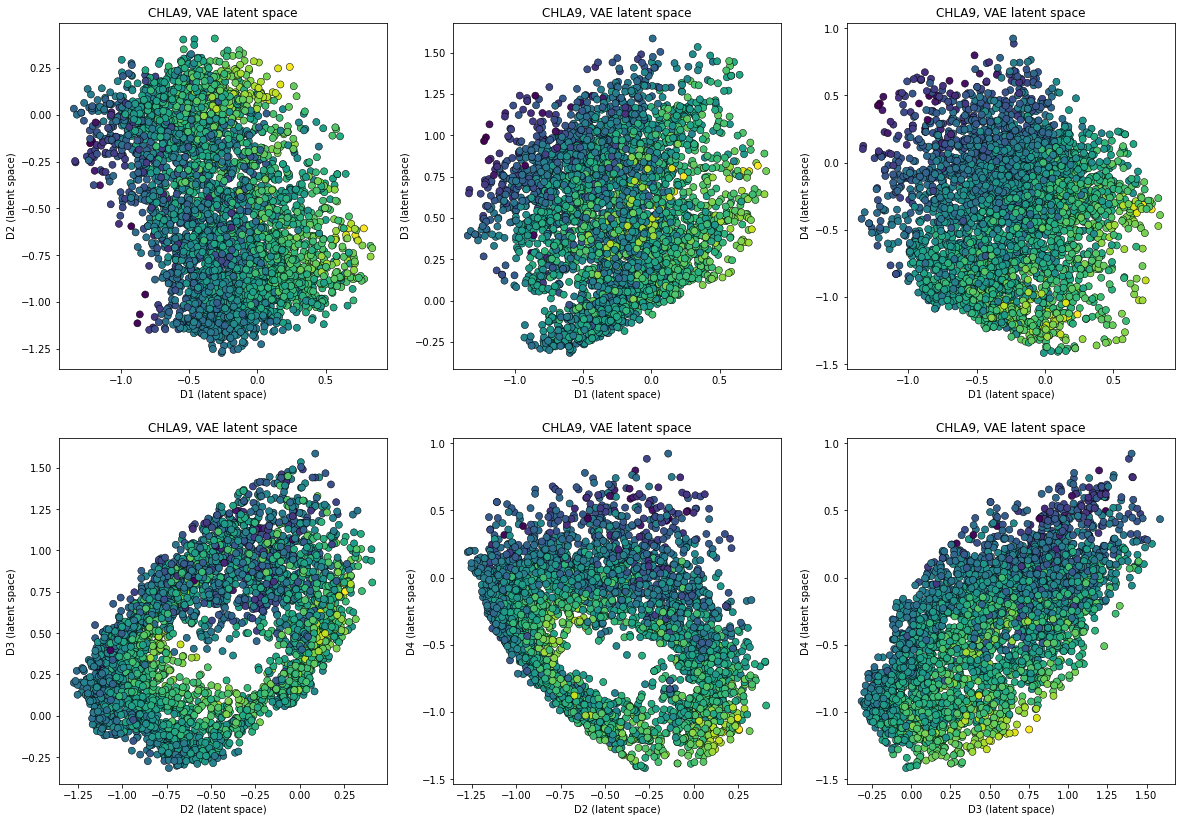

In [94]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=3)

x_test_encoded = encoder.predict(X, batch_size=32)[0]
#x_pca = pca.fit_transform(x_test_encoded)
x_pca = x_test_encoded

plt.figure(figsize=(20, 14))

plt.subplot(2,3,1)
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=X.sum(axis=1), ec='k', linewidth=0.5, s=50)
plt.xlabel("D1 (latent space)")
plt.ylabel("D2 (latent space)")
plt.title("CHLA9, VAE latent space")

plt.subplot(2,3,2)
plt.scatter(x_pca[:, 0], x_pca[:, 2], c=X.sum(axis=1), ec='k', linewidth=0.5, s=50)
plt.xlabel("D1 (latent space)")
plt.ylabel("D3 (latent space)")
plt.title("CHLA9, VAE latent space")

plt.subplot(2,3,3)
plt.scatter(x_pca[:, 0], x_pca[:, 3], c=X.sum(axis=1), ec='k', linewidth=0.5, s=50)
plt.xlabel("D1 (latent space)")
plt.ylabel("D4 (latent space)")
plt.title("CHLA9, VAE latent space")

plt.subplot(2,3,4)
plt.scatter(x_pca[:, 1], x_pca[:, 2], c=X.sum(axis=1), ec='k', linewidth=0.5, s=50)
plt.xlabel("D2 (latent space)")
plt.ylabel("D3 (latent space)")
plt.title("CHLA9, VAE latent space")

plt.subplot(2,3,5)
plt.scatter(x_pca[:, 1], x_pca[:, 3], c=X.sum(axis=1), ec='k', linewidth=0.5, s=50)
plt.xlabel("D2 (latent space)")
plt.ylabel("D4 (latent space)")
plt.title("CHLA9, VAE latent space")

plt.subplot(2,3,6)
plt.scatter(x_pca[:, 2], x_pca[:, 3], c=X.sum(axis=1), ec='k', linewidth=0.5, s=50)
plt.xlabel("D3 (latent space)")
plt.ylabel("D4 (latent space)")
plt.title("CHLA9, VAE latent space")

In [85]:
decoder.predict(x_test_encoded)

array([[0.80321354, 0.8988301 , 0.86574405, ..., 0.01546635, 0.01482931,
        0.02473449],
       [0.84061295, 0.8721945 , 0.8356204 , ..., 0.02038171, 0.0290079 ,
        0.01291054],
       [0.9043235 , 0.88456804, 0.8501123 , ..., 0.01570602, 0.01411751,
        0.02348548],
       ...,
       [0.80023986, 0.89495456, 0.8599335 , ..., 0.01522602, 0.01564843,
        0.02383672],
       [0.81001896, 0.89296633, 0.8583272 , ..., 0.01542525, 0.0159933 ,
        0.02351806],
       [0.8801953 , 0.87678564, 0.846623  , ..., 0.01891262, 0.01714374,
        0.02037937]], dtype=float32)

In [86]:
X

array([[0.7865641 , 0.91298056, 0.8638536 , ..., 0.        , 0.        ,
        0.        ],
       [0.8717873 , 0.8616082 , 0.81668353, ..., 0.02686084, 0.02686084,
        0.        ],
       [0.8777378 , 0.8795083 , 0.86093086, ..., 0.01891197, 0.01891197,
        0.01891197],
       ...,
       [0.7549109 , 0.9349528 , 0.9009535 , ..., 0.        , 0.05770719,
        0.03188498],
       [0.8432484 , 0.9078918 , 0.88419914, ..., 0.        , 0.02553134,
        0.        ],
       [0.8620149 , 0.87187904, 0.8364749 , ..., 0.        , 0.03897276,
        0.        ]], dtype=float32)